## 1. Reading File

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [78]:
#read in file
df = pd.read_csv("../data/cleaned.csv")
df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,residence_type_Urban,smoking_status_Never smoked,smoking_status_Smokes,smoking_status_Unknown
0,0,67.0,0,1,1,228.69,36.60,1,0,0,1,0,1,0,0,0
1,1,61.0,0,0,1,202.21,28.89,1,0,0,0,1,0,1,0,0
2,0,80.0,0,1,1,105.92,32.50,1,0,0,1,0,0,1,0,0
3,1,49.0,0,0,1,171.23,34.40,1,0,0,1,0,1,0,1,0
4,1,79.0,1,0,1,174.12,24.00,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,1,13.0,0,0,0,103.08,18.60,0,0,0,0,0,0,0,0,1
4944,1,81.0,0,0,1,125.20,40.00,0,0,0,0,1,1,1,0,0
4945,1,35.0,0,0,1,82.99,30.60,0,0,0,0,1,0,1,0,0
4946,0,51.0,0,0,1,166.29,25.60,0,0,0,1,0,0,0,0,0


## 2. Setting up X and Y values to Evaluate

In [79]:
x = df.drop('stroke', axis = 1)
y = df['stroke']

#assign x and y and scramble data to seperate datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

In [80]:
#using SMOTE to oversample data in training
smote = SMOTE(random_state = 10)
x_res, y_res = smote.fit_resample(x_train, y_train)
x_res, y_res = shuffle(x_res, y_res, random_state=42)

In [81]:
#check class dist
print(pd.Series(y_train).value_counts())
print(pd.Series(y_res).value_counts())

stroke
0    3759
1     199
Name: count, dtype: int64
stroke
0    3759
1    3759
Name: count, dtype: int64


### Models

In [82]:
def perform_model(model : str, x_train, y_train, x, y):
    #identify chosen model and instantiating model object
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, class_weight = 'balanced', random_state = 2)

    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state = 2)

    elif model == "SVM":
        mod = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = 2)

    elif model == "XGB":
        mod = XGBClassifier(objective = 'multi:softmax', num_class = 4, random_state = 2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors = 5)


    #trains data
    mod.fit(x_train, y_train)

    #create a prediction for model
    prediction = mod.predict(x)

    conf_matrix = confusion_matrix(y, prediction)
    class_report = classification_report(y, prediction, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, prediction)
    fl_weighted = f1_score(y, prediction, average = 'weighted')
    f1_macro = f1_score(y, prediction, average = 'macro')

    #print results
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1 Weighted: {fl_weighted}')
    print(f'F1 Macro: {f1_macro}')
    print(conf_matrix)

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    # Add labels
    class_labels = ["No Stroke", "Stroke"]
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))

    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    
    #remove outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Annotate the matrix with numbers
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

    plt.show()

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       940
           1       0.16      0.34      0.22        50

    accuracy                           0.88       990
   macro avg       0.56      0.62      0.57       990
weighted avg       0.92      0.88      0.90       990

Balanced Accuracy: 0.6221276595744681
F1 Weighted: 0.8963687840809963
F1 Macro: 0.5745446541188144
[[850  90]
 [ 33  17]]


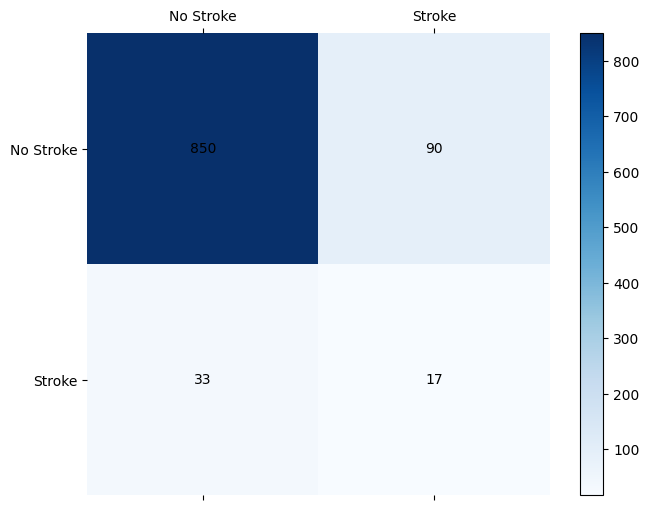

In [83]:
perform_model("Logistic", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       940
           1       0.17      0.16      0.17        50

    accuracy                           0.92       990
   macro avg       0.56      0.56      0.56       990
weighted avg       0.92      0.92      0.92       990

Balanced Accuracy: 0.5597872340425532
F1 Weighted: 0.9175942010336915
F1 Macro: 0.5621019108280255
[[902  38]
 [ 42   8]]


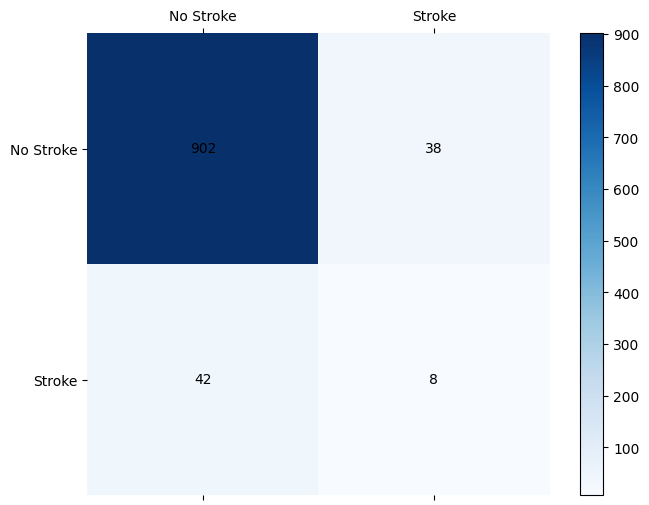

In [84]:
perform_model("RF", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       940
           1       0.13      0.86      0.23        50

    accuracy                           0.71       990
   macro avg       0.56      0.78      0.53       990
weighted avg       0.95      0.71      0.79       990

Balanced Accuracy: 0.7821276595744681
F1 Weighted: 0.79301955983828
F1 Macro: 0.5273386392914519
[[662 278]
 [  7  43]]


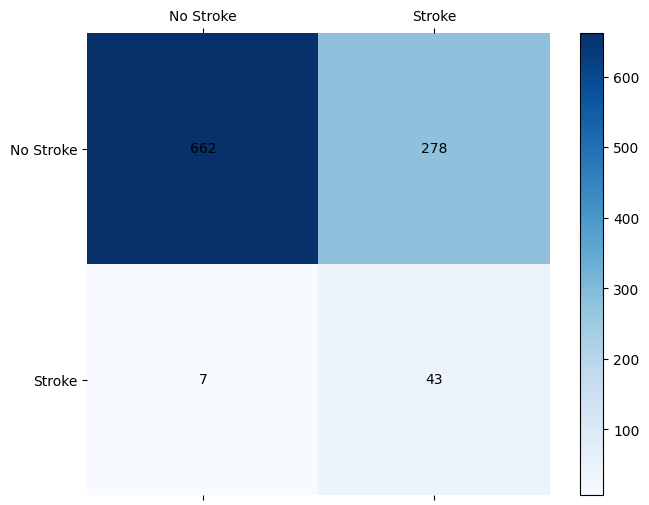

In [85]:
perform_model("SVM", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       940
           1       0.33      0.14      0.20        50

    accuracy                           0.94       990
   macro avg       0.64      0.56      0.58       990
weighted avg       0.92      0.94      0.93       990

Balanced Accuracy: 0.5625531914893618
F1 Weighted: 0.9311031354723576
F1 Macro: 0.5836622669489963
[[926  14]
 [ 43   7]]


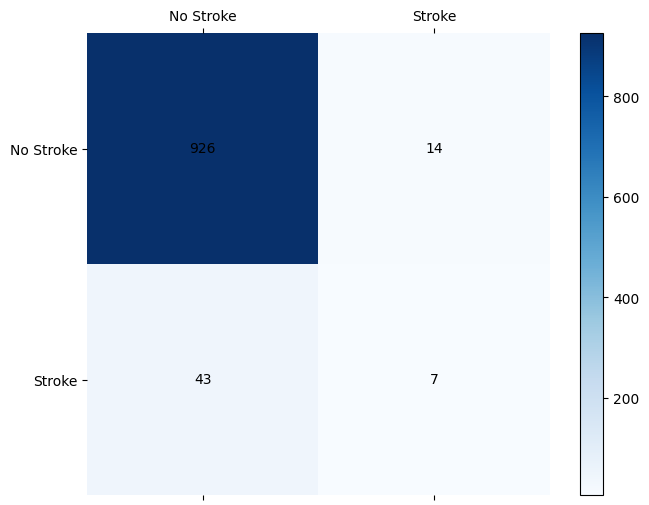

In [86]:
perform_model("XGB", x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       940
           1       0.08      0.02      0.03        50

    accuracy                           0.94       990
   macro avg       0.52      0.50      0.50       990
weighted avg       0.91      0.94      0.92       990

Balanced Accuracy: 0.5041489361702127
F1 Weighted: 0.9214214872326482
F1 Macro: 0.5004877392445087
[[929  11]
 [ 49   1]]


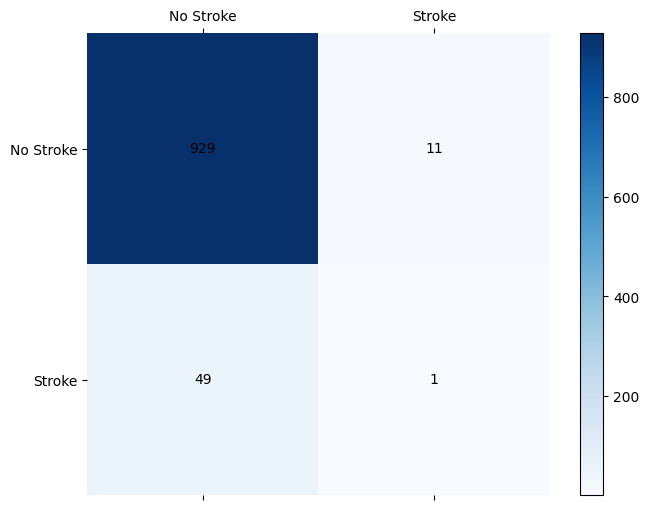

In [87]:
perform_model("KNN", x_train, y_train, x_test, y_test)